# detectron pose inference

- https://detectron2.readthedocs.io/en/latest/tutorials/models.html
- https://github.com/facebookresearch/detectron2/blob/main/MODEL_ZOO.md
- https://dl.fbaipublicfiles.com/detectron2/COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x/137849621/model_final_a6e10b.pkl
- https://colab.research.google.com/drive/16jcaJoc6bCFAQ96jDe2HwtXj7BMD_-m5
- https://detectron2.readthedocs.io/en/latest/modules/config.html?highlight=config#yaml-config-references

In [50]:
from IPython.display import display, Image
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
import cv2
import matplotlib.pyplot as plt

ffmpeg version 4.4.2 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11.3.0 (conda-forge gcc 11.3.0-19)
  configuration: --prefix=/home/conda/feedstock_root/build_artifacts/ffmpeg_1671040255947/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_plac --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1671040255947/_build_env/bin/x86_64-conda-linux-gnu-cc --cxx=/home/conda/feedstock_root/build_artifacts/ffmpeg_1671040255947/_build_env/bin/x86_64-conda-linux-gnu-c++ --nm=/home/conda/feedstock_root/build_artifacts/ffmpeg_1671040255947/_build_env/bin/x86_64-conda-linux-gnu-nm --ar=/home/conda/feedstock_root/build_artifacts/ffmpeg_1671040255947/_build_env/bin/x86_64-conda-linux-gnu-ar --disable-doc --disable-openssl --enable-avresample --enable-demuxer=dash --enable-hardcoded-tables --enable-libfreetype --enable-libfontconfig --enable-libo

Output #0, image2, to '/tmp/test-frame.jpg':
  Metadata:
    major_brand     : isom
    minor_version   : 512
    compatible_brands: isomiso2avc1mp41
    encoder         : Lavf58.76.100
  Stream #0:0(und): Video: mjpeg, yuvj420p(pc, bt709, progressive), 1280x720 [SAR 1:1 DAR 16:9], q=2-31, 200 kb/s, 30 fps, 30 tbn (default)
    Metadata:
      handler_name    : ISO Media file produced by Google Inc. Created on: 11/20/2023.
      vendor_id       : [0][0][0][0]
      encoder         : Lavc58.134.100 mjpeg
    Side data:
      cpb: bitrate max/min/avg: 0/0/200000 buffer size: 0 vbv_delay: N/A
frame=    1 fps=0.0 q=6.9 Lsize=N/A time=00:00:00.03 bitrate=N/A speed=0.00152x    
video:51kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: unknown


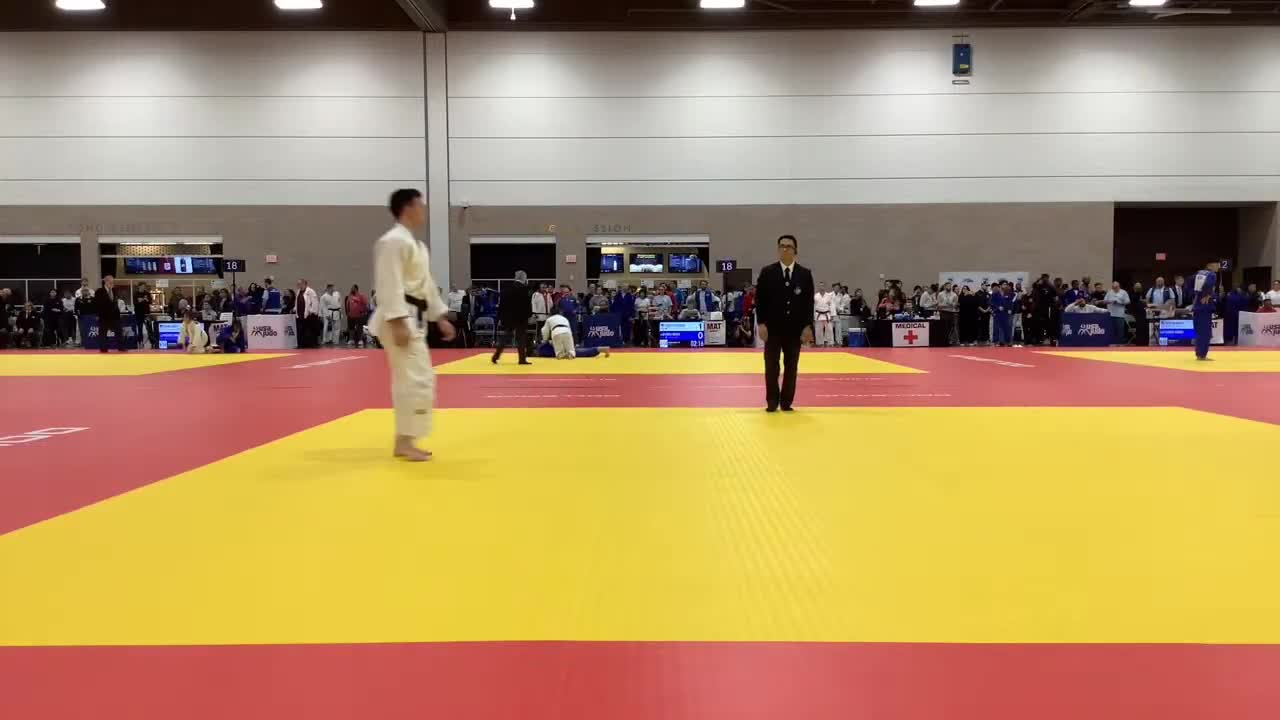

In [26]:
# let's get a single frame from a video and see how it looks
# https://stackoverflow.com/questions/62213783/ffmpeg-error-while-loading-shared-libraries-libopenh264-so-5

source_path = "/home/anthony/judo/processed/mat-2-trunc.mp4"

# https://superuser.com/questions/1009969/how-to-extract-a-frame-out-of-a-video-using-ffmpeg
test_frame = "/tmp/test-frame.jpg"
! rm {test_frame}
! ffmpeg -y -i {source_path} -ss 00:05:00.000 -vframes 1 {test_frame}
display(Image(test_frame))
img = cv2.imread(test_frame)

In [56]:
# cfg = get_cfg()
# model = build_model(cfg)
# model_path = "https://dl.fbaipublicfiles.com/detectron2/COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x/137849621/model_final_a6e10b.pkl"
# DetectionCheckpointer(model).load(model_path)

cfg = get_cfg()
# disable cuda at the moment
cfg.MODEL.DEVICE = "cpu"
cfg.merge_from_file(
    model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml")
)
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(
    "COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml"
)
# only keep the top 5 instances
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8
predictor = DefaultPredictor(cfg)
outputs = predictor(img)

dict_keys(['pred_boxes', 'scores', 'pred_classes', 'pred_keypoints', 'pred_keypoint_heatmaps'])
torch.Size([17, 17, 3])


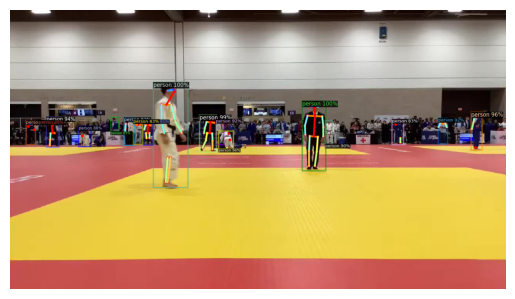

In [58]:
instances = outputs["instances"]
print(instances.__dict__["_fields"].keys())

# show the keypoints
print(instances.pred_keypoints.shape)

# visualize
v = Visualizer(img[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
# correct for color
out_img = out.get_image()[:, :, ::-1]
rgb_img = cv2.cvtColor(out_img, cv2.COLOR_BGR2RGB)
plt.imshow(rgb_img)
# remove axis
plt.axis("off")
plt.show()

In [74]:
instances.pred_keypoints.shape, instances.pred_keypoint_heatmaps.shape

(torch.Size([17, 17, 3]), torch.Size([17, 17, 56, 56]))